In [1]:
import numpy as np
import openmdao.api as om
import dymos as dm
import matplotlib.pyplot as plt
import matplotlib as mpl

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from ODE.combinedODE import CombinedODE
from ODE.spline import (get_spline, get_track_points, get_gate_normals,
                                           reverse_transform_gates, set_gate_displacements,
                                           transform_gates, )
from ODE.linewidthhelper import linewidth_from_data_units
from ODE.tracks import ovaltrack  # track curvature imports

# change track here and in curvature.py. Tracks are defined in tracks.py
track = ovaltrack

# generate nodes along the centerline for curvature calculation (different
# than collocation nodes)
points = get_track_points(track)

# fit the centerline spline.
finespline, gates, gatesd, curv, slope = get_spline(points, s=0.0)
# by default 10000 points
s_final = track.get_total_length()

# Define the OpenMDAO problem
p = om.Problem(model=om.Group())

# Define a Trajectory object
traj = dm.Trajectory()
p.model.add_subsystem('traj', subsys=traj)

# Define a Dymos Phase object with GaussLobatto Transcription
phase = dm.Phase(ode_class=CombinedODE,
                 transcription=dm.GaussLobatto(num_segments=50, order=3, compressed=True))

traj.add_phase(name='phase0', phase=phase)

# Set the time options, in this problem we perform a change of variables. So 'time' is
# actually 's' (distance along the track centerline)
# This is done to fix the collocation nodes in space, which saves us the calculation of
# the rate of change of curvature.
# The state equations are written with respect to time, the variable change occurs in
# timeODE.py
phase.set_time_options(fix_initial=True, fix_duration=True, duration_val=s_final,
                       targets=['curv.s'], units='m', duration_ref=s_final,
                       duration_ref0=10, name='s')

# Define states
phase.add_state('t', fix_initial=True, fix_final=False, units='s', lower=0,
                rate_source='dt_ds', ref=100)  # time
phase.add_state('n', fix_initial=False, fix_final=False, units='m', upper=4.0, lower=-4.0,
                rate_source='dn_ds', targets=['n'],
                ref=4.0)  # normal distance to centerline. The bounds on n define the
# width of the track
phase.add_state('V', fix_initial=False, fix_final=False, units='m/s', ref=40, ref0=5,
                rate_source='dV_ds', targets=['V'])  # velocity
phase.add_state('alpha', fix_initial=False, fix_final=False, units='rad',
                rate_source='dalpha_ds', targets=['alpha'],
                ref=0.15)  # vehicle heading angle with respect to centerline
phase.add_state('lambda', fix_initial=False, fix_final=False, units='rad',
                rate_source='dlambda_ds', targets=['lambda'],
                ref=0.01)  # vehicle slip angle, or angle between the axis of the vehicle
# and velocity vector (all cars drift a little)
phase.add_state('omega', fix_initial=False, fix_final=False, units='rad/s',
                rate_source='domega_ds', targets=['omega'], ref=0.3)  # yaw rate
phase.add_state('ax', fix_initial=False, fix_final=False, units='m/s**2',
                rate_source='dax_ds', targets=['ax'], ref=8)  # longitudinal acceleration
phase.add_state('ay', fix_initial=False, fix_final=False, units='m/s**2',
                rate_source='day_ds', targets=['ay'], ref=8)  # lateral acceleration

# Define Controls
phase.add_control(name='delta', units='rad', lower=None, upper=None, fix_initial=False,
                  fix_final=False, ref=0.04, rate_continuity=True)  # steering angle
phase.add_control(name='thrust', units=None, fix_initial=False, fix_final=False, rate_continuity=True)
# the thrust controls the longitudinal force of the rear tires and is positive while accelerating, negative while braking

# Performance Constraints
pmax = 960000  # W
phase.add_path_constraint('power', upper=pmax, ref=100000)  # engine power limit

# The following four constraints are the tire friction limits, with 'rr' designating the
# rear right wheel etc. This limit is computed in tireConstraintODE.py
phase.add_path_constraint('c_rr', upper=1)
phase.add_path_constraint('c_rl', upper=1)
phase.add_path_constraint('c_fr', upper=1)
phase.add_path_constraint('c_fl', upper=1)

# Some of the vehicle design parameters are available to set here. Other parameters can
# be found in their respective ODE files.
phase.add_parameter('M', val=800.0, units='kg', opt=False,
                    targets=['car.M', 'tire.M', 'tireconstraint.M', 'normal.M'],
                    static_target=True)  # vehicle mass
phase.add_parameter('beta', val=0.62, units=None, opt=False, targets=['tire.beta'],
                    static_target=True)  # brake bias
phase.add_parameter('CoP', val=1.6, units='m', opt=False, targets=['normal.CoP'],
                    static_target=True)  # center of pressure location
phase.add_parameter('h', val=0.3, units='m', opt=False, targets=['normal.h'],
                    static_target=True)  # center of gravity height
phase.add_parameter('chi', val=0.5, units=None, opt=False, targets=['normal.chi'],
                    static_target=True)  # roll stiffness
phase.add_parameter('ClA', val=4.0, units='m**2', opt=False, targets=['normal.ClA'],
                    static_target=True)  # downforce coefficient*area
phase.add_parameter('CdA', val=2.0, units='m**2', opt=False, targets=['car.CdA'],
                    static_target=True)  # drag coefficient*area

# Minimize final time.
# note that we use the 'state' time instead of Dymos 'time'
phase.add_objective('t', loc='final')

# Add output timeseries
phase.add_timeseries_output('*')
phase.add_timeseries_output('t', output_name='time')

# Link the states at the start and end of the phase in order to ensure a continous lap
traj.link_phases(phases=['phase0', 'phase0'],
                 vars=['V', 'n', 'alpha', 'omega', 'lambda', 'ax', 'ay'],
                 locs=('final', 'initial'))

# Set the driver. IPOPT or SNOPT are recommended but SLSQP might work.
p.driver = om.pyOptSparseDriver(optimizer='IPOPT')

p.driver.opt_settings['mu_init'] = 1e-3
p.driver.opt_settings['max_iter'] = 500
p.driver.opt_settings['acceptable_tol'] = 1e-3
p.driver.opt_settings['constr_viol_tol'] = 1e-3
p.driver.opt_settings['compl_inf_tol'] = 1e-3
p.driver.opt_settings['acceptable_iter'] = 0
p.driver.opt_settings['tol'] = 1e-3
p.driver.opt_settings['print_level'] = 0
p.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'  # for faster convergence
p.driver.opt_settings['alpha_for_y'] = 'safer-min-dual-infeas'
p.driver.opt_settings['mu_strategy'] = 'monotone'
p.driver.opt_settings['bound_mult_init_method'] = 'mu-based'
p.driver.options['print_results'] = False

# Allow OpenMDAO to automatically determine our sparsity pattern.
# Doing so can significant speed up the execution of Dymos.
p.driver.declare_coloring()

# Setup the problem
p.setup(check=True)  # force_alloc_complex=True
# Now that the OpenMDAO problem is setup, we can set the values of the states.

# States
# Nonzero velocity to avoid division by zero errors
p.set_val('traj.phase0.states:V', phase.interp('V', [20, 20]), units='m/s')
# All other states start at 0
p.set_val('traj.phase0.states:lambda', phase.interp('lambda', [0.0, 0.0]), units='rad')
p.set_val('traj.phase0.states:omega', phase.interp('omega', [0.0, 0.0]), units='rad/s')
p.set_val('traj.phase0.states:alpha', phase.interp('alpha', [0.0, 0.0]), units='rad')
p.set_val('traj.phase0.states:ax', phase.interp('ax', [0.0, 0.0]), units='m/s**2')
p.set_val('traj.phase0.states:ay', phase.interp('ay', [0.0, 0.0]), units='m/s**2')
p.set_val('traj.phase0.states:n', phase.interp('n', [0.0, 0.0]), units='m')
# initial guess for what the final time should be
p.set_val('traj.phase0.states:t', phase.interp('t', [0.0, 100.0]), units='s')

# Controls
# a small amount of thrust can speed up convergence
p.set_val('traj.phase0.controls:delta', phase.interp('delta', [0.0, 0.0]), units='rad')
p.set_val('traj.phase0.controls:thrust', phase.interp('thrust', [0.1, 0.1]), units=None)

dm.run_problem(p, run_driver=True)
print('Optimization finished')




--- Constraint Report [traj] ---
    --- phase0 ---
        [path]     power <= 9.6000e+05  [W]
        [path]     c_rr <= 1.0000e+00  [None]
        [path]     c_rl <= 1.0000e+00  [None]
        [path]     c_fr <= 1.0000e+00  [None]
        [path]     c_fl <= 1.0000e+00  [None]

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Model viewer data has already been recorded for Driver.
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings
Model viewer data has already been recorded for Driver.
INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorder

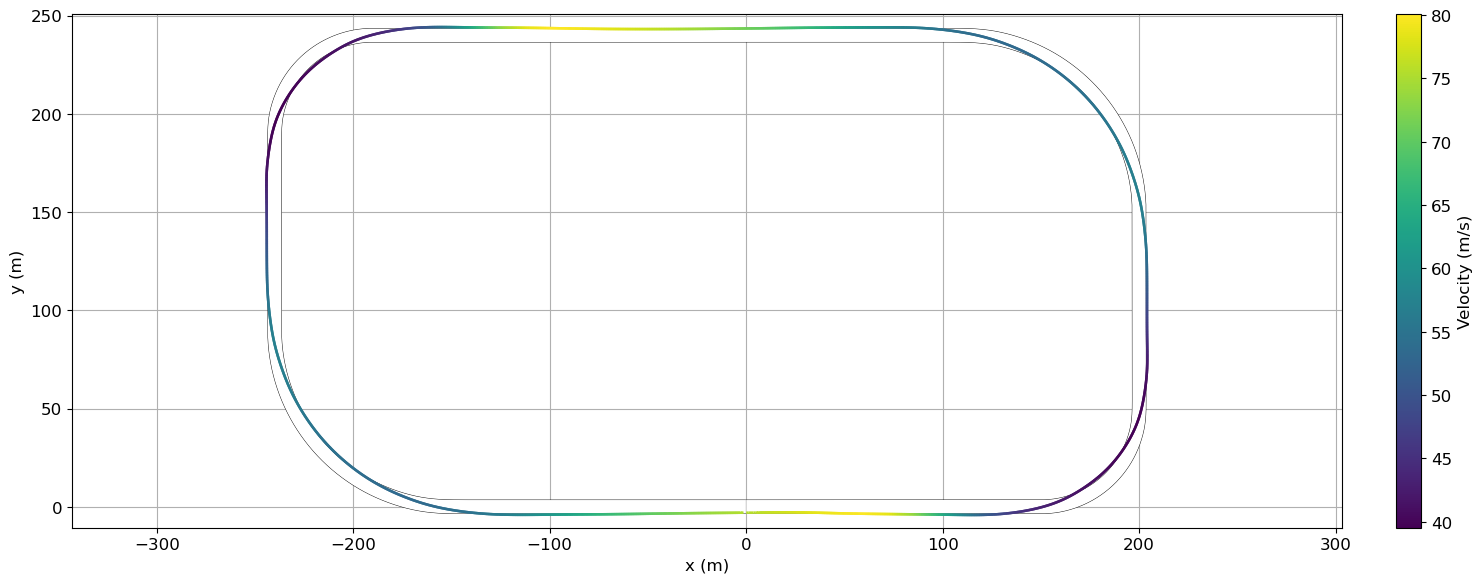

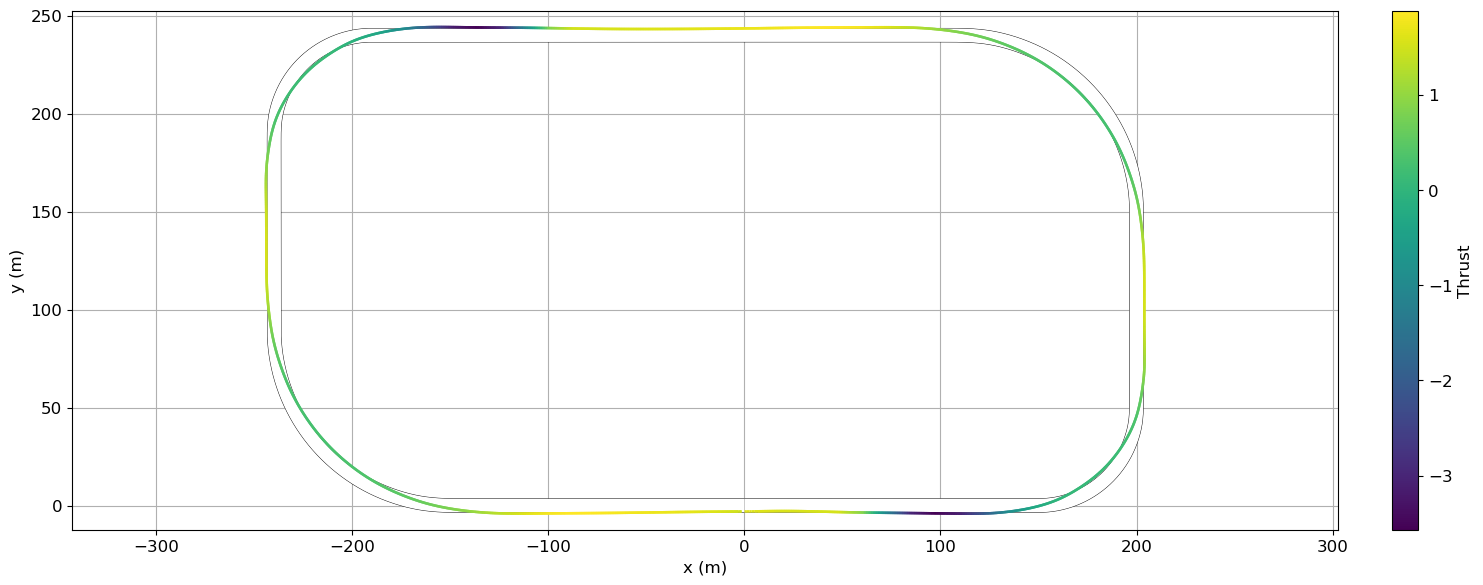

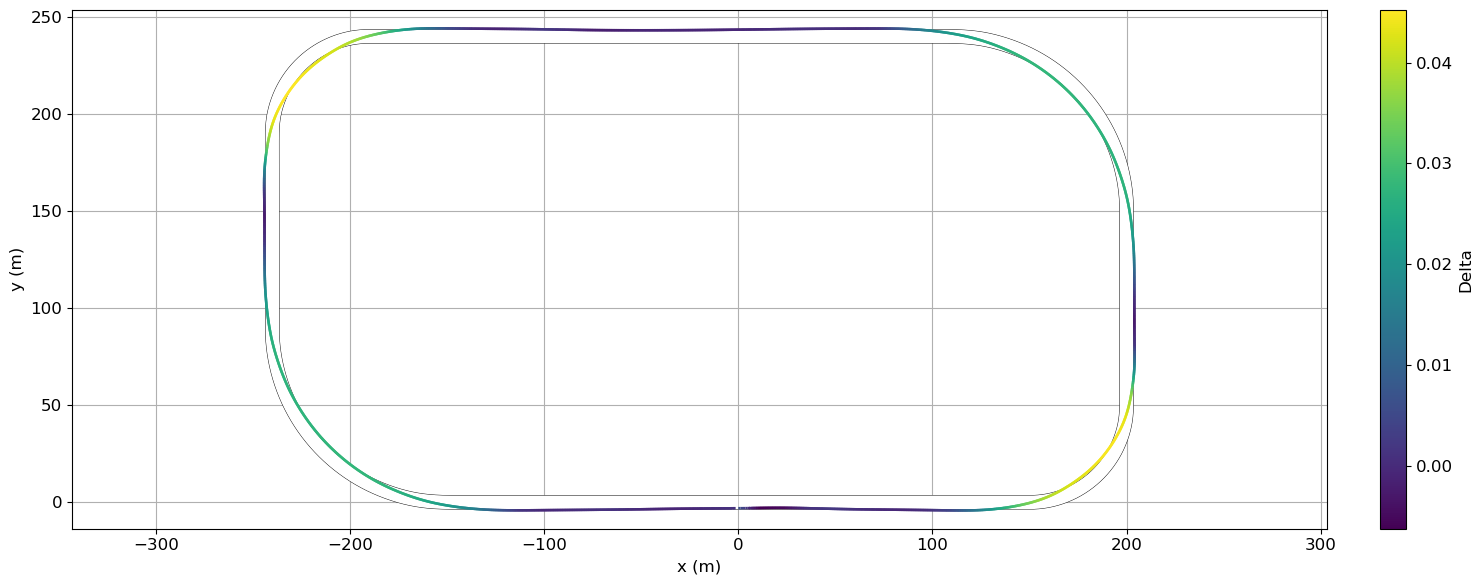

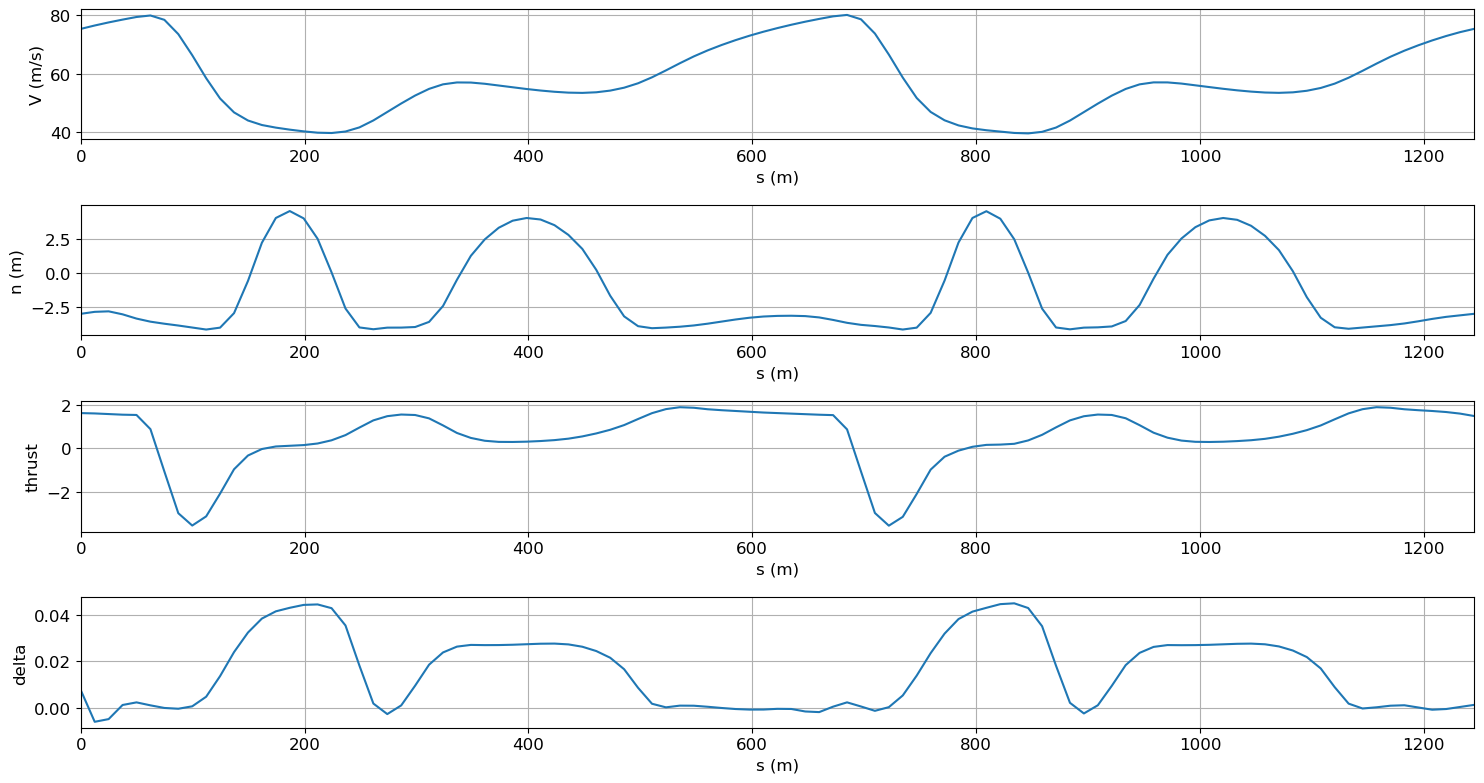

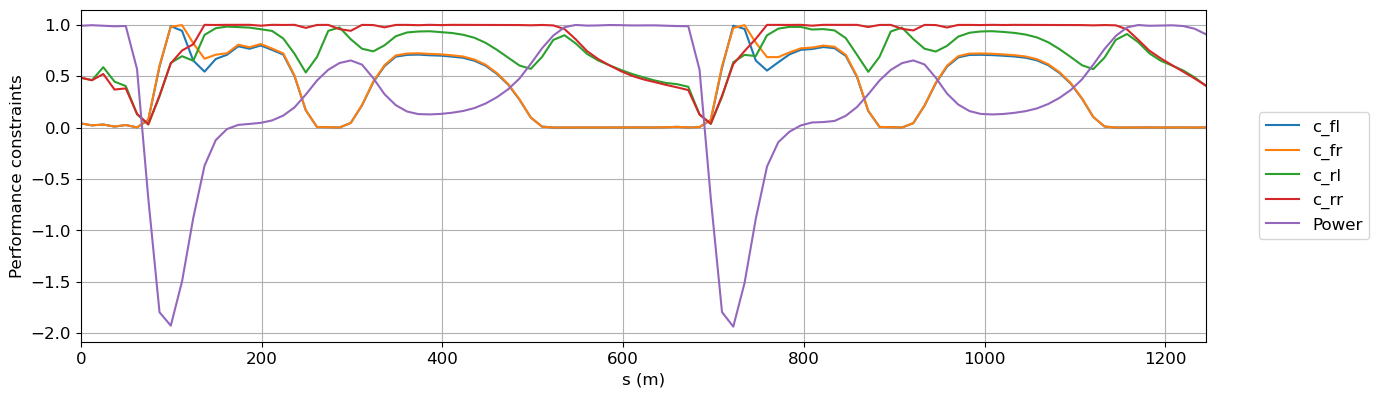

In [3]:
# Get optimized time series
n = p.get_val('traj.phase0.timeseries.n')
s = p.get_val('traj.phase0.timeseries.s')
V = p.get_val('traj.phase0.timeseries.V')
thrust = p.get_val('traj.phase0.timeseries.thrust')
delta = p.get_val('traj.phase0.timeseries.delta')
power = p.get_val('traj.phase0.timeseries.power', units='W')

# We know the optimal distance from the centerline (n). To transform this into the racing
# line we fit a spline to the displaced points. This will let us plot the racing line in
# x/y coordinates
normals = get_gate_normals(finespline, slope)
newgates = []
newnormals = []
newn = []
for i in range(len(n)):
    index = ((s[i] / s_final) * np.array(finespline).shape[1]).astype(
        int)  # interpolation to find the appropriate index
    if index[0] == np.array(finespline).shape[1]:
        index[0] = np.array(finespline).shape[1] - 1
    if i > 0 and s[i] == s[i - 1]:
        continue
    else:
        newgates.append([finespline[0][index[0]], finespline[1][index[0]]])
        newnormals.append(normals[index[0]])
        newn.append(n[i][0])

newgates = reverse_transform_gates(newgates)
displaced_gates = set_gate_displacements(newn, newgates, newnormals)
displaced_gates = np.array((transform_gates(displaced_gates)))

npoints = 1000
# fit the racing line spline to npoints
displaced_spline, gates, gatesd, curv, slope = get_spline(displaced_gates, 1 / npoints, 0)

plt.rcParams.update({'font.size': 12})

def plot_track_with_data(state, s):
    # this function plots the track
    state = np.array(state)[:, 0]
    s = np.array(s)[:, 0]
    s_new = np.linspace(0, s_final, npoints)

    # Colormap and norm of the track plot
    cmap = mpl.cm.get_cmap('viridis')
    norm = mpl.colors.Normalize(vmin=np.amin(state), vmax=np.amax(state))

    fig, ax = plt.subplots(figsize=(15, 6))
    # establishes the figure axis limits needed for plotting the track below
    plt.plot(displaced_spline[0], displaced_spline[1], linewidth=0.1, solid_capstyle="butt")

    plt.axis('equal')
    # the linewidth is set in order to match the width of the track
    plt.plot(finespline[0], finespline[1], 'k',
             linewidth=linewidth_from_data_units(8.5, ax),
             solid_capstyle="butt")
    plt.plot(finespline[0], finespline[1], 'w', linewidth=linewidth_from_data_units(8, ax),
             solid_capstyle="butt")  # 8 is the width, and the 8.5 wide line draws 'kerbs'
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')

    # plot spline with color
    for i in range(1, len(displaced_spline[0])):
        s_spline = s_new[i]
        index_greater = np.argwhere(s >= s_spline)[0][0]
        index_less = np.argwhere(s < s_spline)[-1][0]

        x = s_spline
        xp = np.array([s[index_less], s[index_greater]])
        fp = np.array([state[index_less], state[index_greater]])
        interp_state = np.interp(x, xp,
                                 fp)  # interpolate the given state to calculate the color

        # calculate the appropriate color
        state_color = norm(interp_state)
        color = cmap(state_color)
        color = mpl.colors.to_hex(color)

        # the track plot consists of thousands of tiny lines:
        point = [displaced_spline[0][i], displaced_spline[1][i]]
        prevpoint = [displaced_spline[0][i - 1], displaced_spline[1][i - 1]]
        if i <= 5 or i == len(displaced_spline[0]) - 1:
            plt.plot([point[0], prevpoint[0]], [point[1], prevpoint[1]], color,
                     linewidth=linewidth_from_data_units(1.5, ax), solid_capstyle="butt",
                     antialiased=True)
        else:
            plt.plot([point[0], prevpoint[0]], [point[1], prevpoint[1]], color,
                     linewidth=linewidth_from_data_units(1.5, ax),
                     solid_capstyle="projecting", antialiased=True)

    clb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), fraction=0.02,
                       ax=ax, pad=0.04)  # add colorbar

    if np.array_equal(state, V[:, 0]):
        clb.set_label('Velocity (m/s)')
    elif np.array_equal(state, thrust[:, 0]):
        clb.set_label('Thrust')
    elif np.array_equal(state, delta[:, 0]):
        clb.set_label('Delta')

    plt.tight_layout()
    plt.grid()

# Create the plots
plot_track_with_data(V, s)
plot_track_with_data(thrust, s)
plot_track_with_data(delta, s)

# Plot the main vehicle telemetry
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 8))

# Velocity vs s
axes[0].plot(s,
             p.get_val('traj.phase0.timeseries.V'), label='solution')

axes[0].set_xlabel('s (m)')
axes[0].set_ylabel('V (m/s)')
axes[0].grid()
axes[0].set_xlim(0, s_final)

# n vs s
axes[1].plot(s,
             p.get_val('traj.phase0.timeseries.n', units='m'), label='solution')

axes[1].set_xlabel('s (m)')
axes[1].set_ylabel('n (m)')
axes[1].grid()
axes[1].set_xlim(0, s_final)

# throttle vs s
axes[2].plot(s, thrust)

axes[2].set_xlabel('s (m)')
axes[2].set_ylabel('thrust')
axes[2].grid()
axes[2].set_xlim(0, s_final)

# delta vs s
axes[3].plot(s,
             p.get_val('traj.phase0.timeseries.delta', units=None),
             label='solution')

axes[3].set_xlabel('s (m)')
axes[3].set_ylabel('delta')
axes[3].grid()
axes[3].set_xlim(0, s_final)

plt.tight_layout()

# Performance constraint plot. Tire friction and power constraints
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 4))
plt.subplots_adjust(right=0.82, bottom=0.14, top=0.97, left=0.07)

axes.plot(s,
          p.get_val('traj.phase0.timeseries.c_fl', units=None), label='c_fl')
axes.plot(s,
          p.get_val('traj.phase0.timeseries.c_fr', units=None), label='c_fr')
axes.plot(s,
          p.get_val('traj.phase0.timeseries.c_rl', units=None), label='c_rl')
axes.plot(s,
          p.get_val('traj.phase0.timeseries.c_rr', units=None), label='c_rr')

axes.plot(s, power / pmax, label='Power')

axes.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
axes.set_xlabel('s (m)')
axes.set_ylabel('Performance constraints')
axes.grid()
axes.set_xlim(0, s_final)
plt.show()